In [741]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt



### Resolution of NIRSpec gratings around the `[O II] 3727, 3729` doublet

In [848]:
df[df.GroupID.isin([122, 261, 1933, 3486])]

,GroupID,FWHM_OII_3727
2,1933,111.472177
3,3486,109.467747
23,122,142.348281
24,261,171.145297
60,3486,172.660168


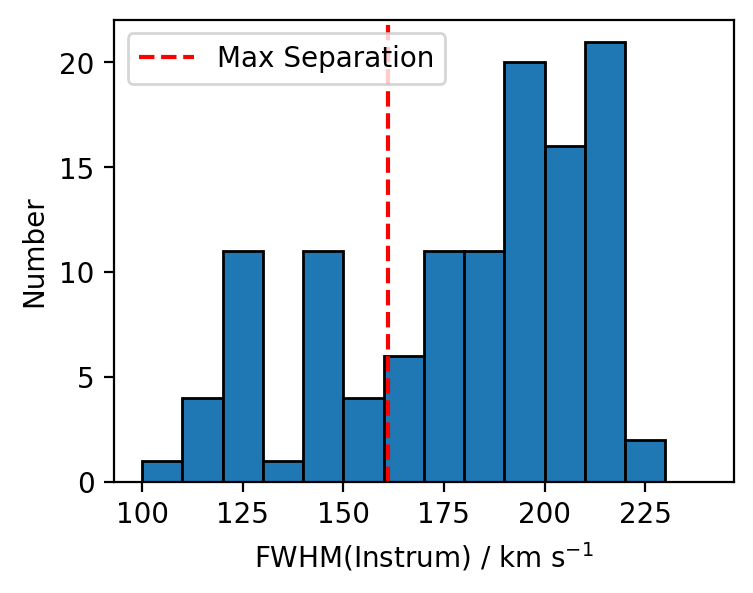

In [958]:
# load the gratings resolution table
df = pd.read_csv('fwhm_OII_3727.txt', names=['GroupID', 'FWHM_OII_3727'])
fwhm = df['FWHM_OII_3727'].values
bins = np.arange(100, 250, 10)

# velocity difference between doublet lines
delta_fwhm = abs(3727 - 3729) / 3727 * 3e5

# plot the histogram of resolution values
fig, ax = plt.subplots(1, figsize=(4, 3), dpi=200)
ax.set_xlabel('FWHM(Instrum) / km s$^{-1}$')
ax.set_ylabel('Number')

ax.hist(fwhm, bins=bins, edgecolor='k',)
ax.axvline(delta_fwhm, color='r', linestyle='--', label="Max Separation")
ax.legend()
plt.show()

Fit results:
A1 = 1.27813 ± 0.08452
A2 = 0.85389 ± 0.04448
peak1 = 21.06774 ± 5.64195
peak2 = 323.30644 ± 6.13694
fwhm = 270.59018 ± 10.13808


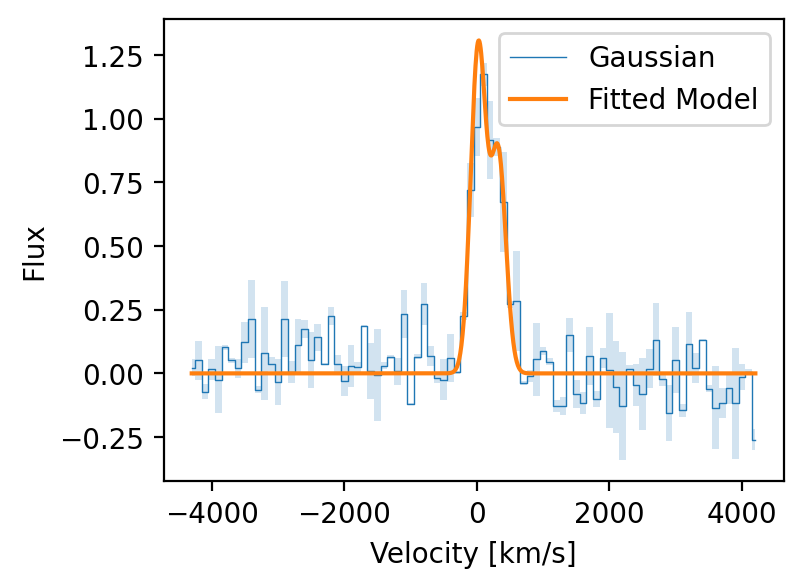

In [875]:
from scipy.optimize import least_squares

fwhm_kms = 200 # km/s
sep = 1.5

x_kms = np.arange(-fwhm_kms*(20+sep), fwhm_kms*(20+sep), fwhm_kms/2)

peak1_kms = 0.0
peak2_kms = peak1_kms + sep * fwhm_kms

y1 = np.exp(-0.5 * ((x_kms - peak1_kms) / (2*fwhm_kms/2.355))**2)
y2 = np.exp(-0.5 * ((x_kms - peak2_kms) / (2*fwhm_kms/2.355))**2)
y = y1 + y2
obs_err = 0.1
y_mock = y / np.max(y) + np.random.normal(loc=0, scale=obs_err, size=y.shape)
ye_mock = np.random.normal(loc=0, scale=obs_err, size=y_mock.shape)



def func(x, A1, A2, peak1, peak2, fwhm):
    y1 = A1 * np.exp(-0.5 * (x - peak1)**2 / (fwhm/2.355)**2)
    y2 = A2 * np.exp(-0.5 * (x - peak2)**2 / (fwhm/2.355)**2)
    return (y1 + y2)

def residuals(params, x, y, ye):
    A1, A2, peak1, peak2, fwhm = params
    model_y = func(x, A1, A2, peak1, peak2, fwhm)
    return (y - model_y) / abs(ye)

# Convert start_params dictionary to a list of values for x0
start_params = {
    "A1": 2,
    "A2": 2,
    "peak1": peak1_kms,
    "peak2": peak2_kms,
    "fwhm": fwhm_kms,
}
x0 = list(start_params.values())

# Perform minimization
result = least_squares(
    residuals, 
    x0,
    args=(x_kms, y_mock, ye_mock),
    method='lm',
)

# Extract covariance matrix and parameter uncertainties
if result.success and result.jac is not None:
    J = result.jac  # Jacobian matrix
    try:
        cov_matrix = np.linalg.inv(J.T @ J)  # Approximate Hessian inversion
        param_uncertainties = np.sqrt(np.diag(cov_matrix))  # Standard deviations
    except np.linalg.LinAlgError:
        cov_matrix = None
        param_uncertainties = None
        print("Warning: Hessian is singular, cannot compute uncertainties.")
else:
    param_uncertainties = None

# Print results
print("Fit results:")
for param_name, value in zip(start_params.keys(), result.x):
    uncertainty = param_uncertainties[list(start_params.keys()).index(param_name)] if param_uncertainties is not None else None
    if uncertainty is not None:
        print(f"{param_name} = {value:.5f} ± {uncertainty:.5f}")
    else:
        print(f"{param_name} = {value:.5f} (uncertainty unavailable)")


# Plot the mock data with error bars
fig, ax = plt.subplots(1, figsize=(4, 3), dpi=200)

ax.step(x_kms, y_mock, where='mid', label='Gaussian', 
        color='C0', ls='-', lw=0.5)
ax.fill_between(x_kms, y_mock-ye_mock, y_mock+ye_mock, color='C0', step='mid', 
                alpha=0.2, lw=0)

# Plot the fitted model
x_eval = np.linspace(x_kms.min(), x_kms.max(), 1000)
fitted_y = func(x_eval, *result.x)
ax.plot(x_eval, fitted_y, label='Fitted Model', color='C1', lw=1.5)

# Add labels and legend
ax.set_xlabel('Velocity [km/s]')
ax.set_ylabel('Flux')
ax.legend()
plt.show()


### Testing parameter recovery at different line separations

In [876]:
from scipy.optimize import least_squares

def func(x, A1, A2, peak1, peak2, fwhm):
        y1 = A1 * np.exp(-0.5 * (x - peak1)**2 / (fwhm/2.355)**2)
        y2 = A2 * np.exp(-0.5 * (x - peak2)**2 / (fwhm/2.355)**2)
        return (y1 + y2)

def residuals(params, x, y, ye):
    A1, A2, peak1, peak2, fwhm = params
    model_y = func(x, A1, A2, peak1, peak2, fwhm)
    return (y - model_y) / abs(ye)

# loop over separations
fwhm_kms = 200 # km/s
sep_array = np.arange(0.6, 6, 0.05)
n_iter = 300

param_errors = []
recovery_errors = []
for sep in sep_array:
    for i_iter in range(n_iter):
        x_kms = np.arange(-fwhm_kms*(20+sep), fwhm_kms*(20+sep), fwhm_kms/2)

        peak1_kms = 0.0
        peak2_kms = peak1_kms + sep * fwhm_kms

        y1 = np.exp(-0.5 * ((x_kms - peak1_kms) / (2*fwhm_kms/2.355))**2)
        y2 = np.exp(-0.5 * ((x_kms - peak2_kms) / (2*fwhm_kms/2.355))**2)
        y = y1 + y2
        obs_err = 0.1
        y_mock = y + np.random.normal(loc=0, scale=obs_err, size=y.shape)
        ye_mock = np.random.normal(loc=0, scale=obs_err, size=y_mock.shape)
        
        # Convert start_params dictionary to a list of values for x0
        start_params = {
            "A1": 2,
            "A2": 2,
            "peak1": peak1_kms,
            "peak2": peak2_kms,
            "fwhm": fwhm_kms,
        }
        x0 = list(start_params.values())

        # Perform minimization
        result = least_squares(
            residuals, 
            x0,
            args=(x_kms, y_mock, ye_mock),
            method='lm',
        )

        # Extract covariance matrix and parameter uncertainties
        if result.success and result.jac is not None:
            J = result.jac  # Jacobian matrix
            try:
                cov_matrix = np.linalg.inv(J.T @ J)  # Approximate Hessian inversion
                param_uncertainties = np.sqrt(np.diag(cov_matrix))  # Standard deviations
            except np.linalg.LinAlgError:
                cov_matrix = None
                param_uncertainties = [np.nan for i in range(len(start_params))]
                #print("Warning: Hessian is singular, cannot compute uncertainties.")
        else:
            param_uncertainties = [np.nan for i in range(len(start_params))]


        param_errors.append(param_uncertainties / result.x)
        recovery_errors.append(np.abs(result.x - np.array(list(start_params.values()))) / np.array(list(start_params.values())))
        recovery_errors[-1][2] = np.abs(fwhm_kms - result.x[2]) / fwhm_kms

param_errors = np.array(param_errors).reshape(-1, n_iter, 
                                              len(start_params))
recovery_errors = np.array(recovery_errors).reshape(-1, n_iter, 
                                                    len(start_params))

param_errors = np.nanmedian(param_errors, axis=1)
recovery_errors = np.nanmedian(recovery_errors, axis=1)

/var/folders/9d/00nglqw90sj91gxry7b4gxtw0000gp/T/ipykernel_35895/817796828.py:67: RuntimeWarning: divide by zero encountered in divide
  recovery_errors.append(np.abs(result.x - np.array(list(start_params.values()))) / np.array(list(start_params.values())))
/var/folders/9d/00nglqw90sj91gxry7b4gxtw0000gp/T/ipykernel_35895/817796828.py:57: RuntimeWarning: invalid value encountered in sqrt
  param_uncertainties = np.sqrt(np.diag(cov_matrix))  # Standard deviations


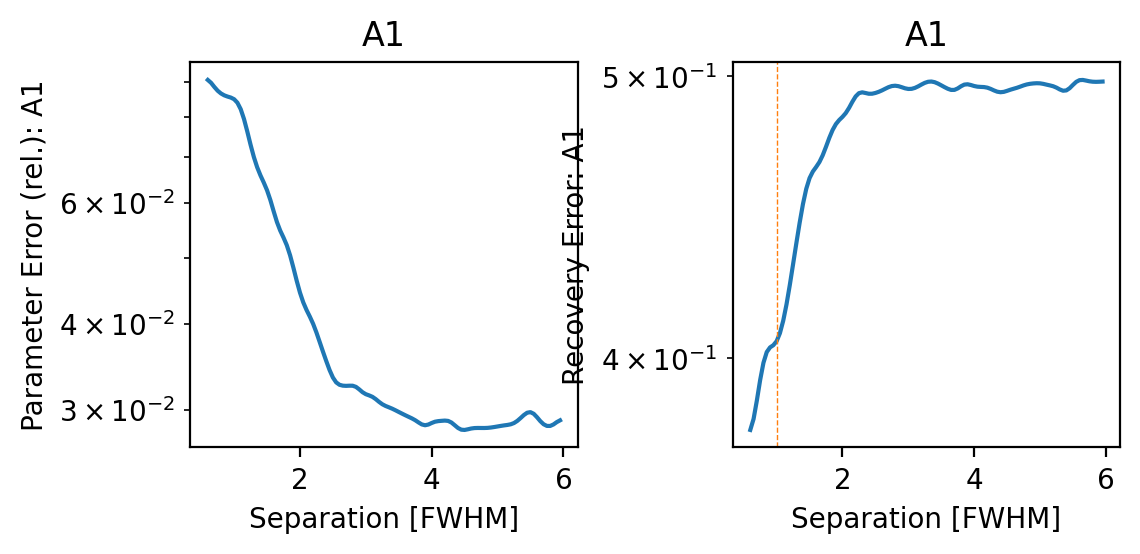

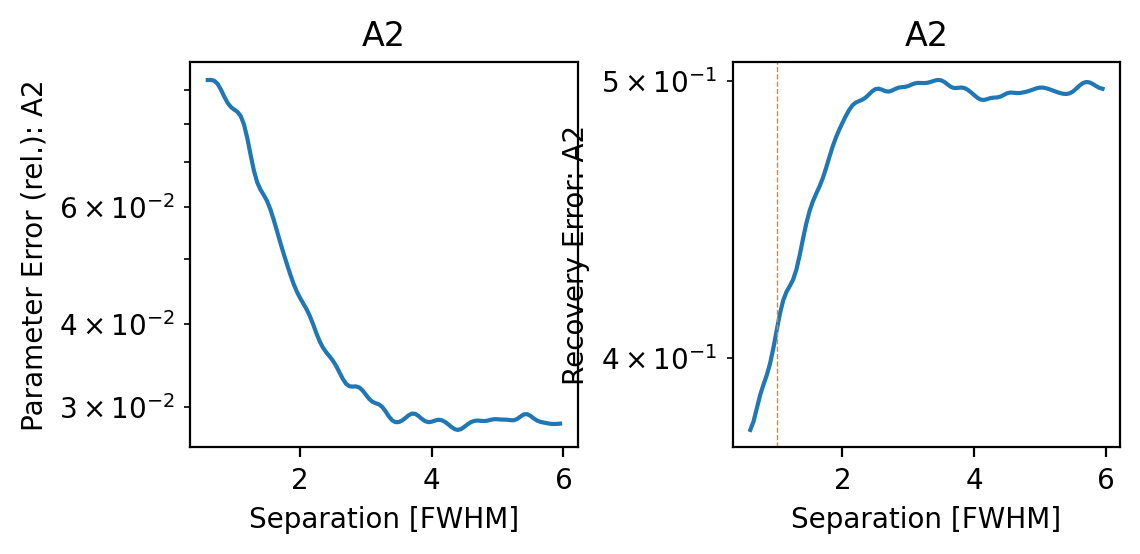

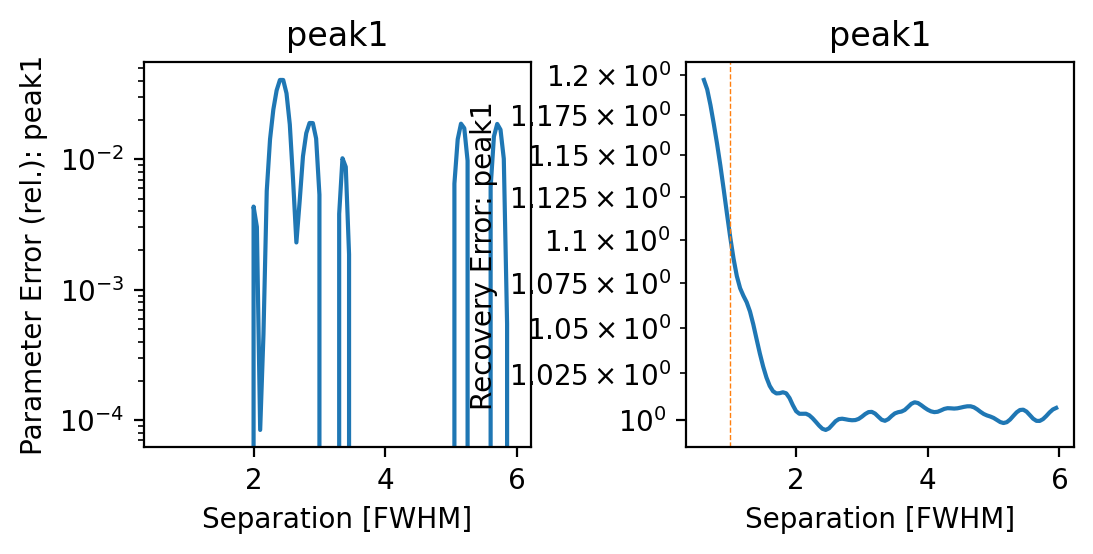

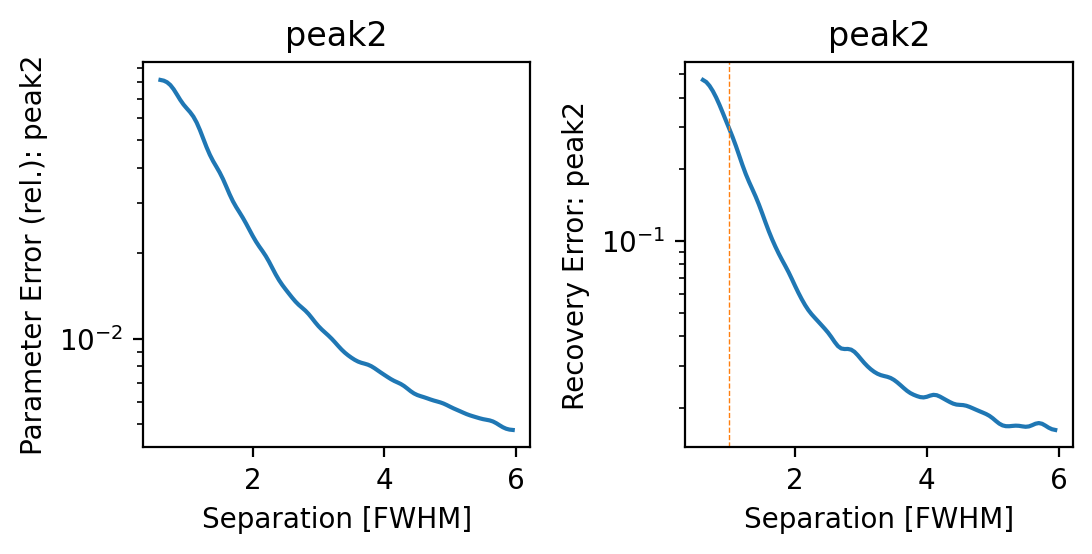

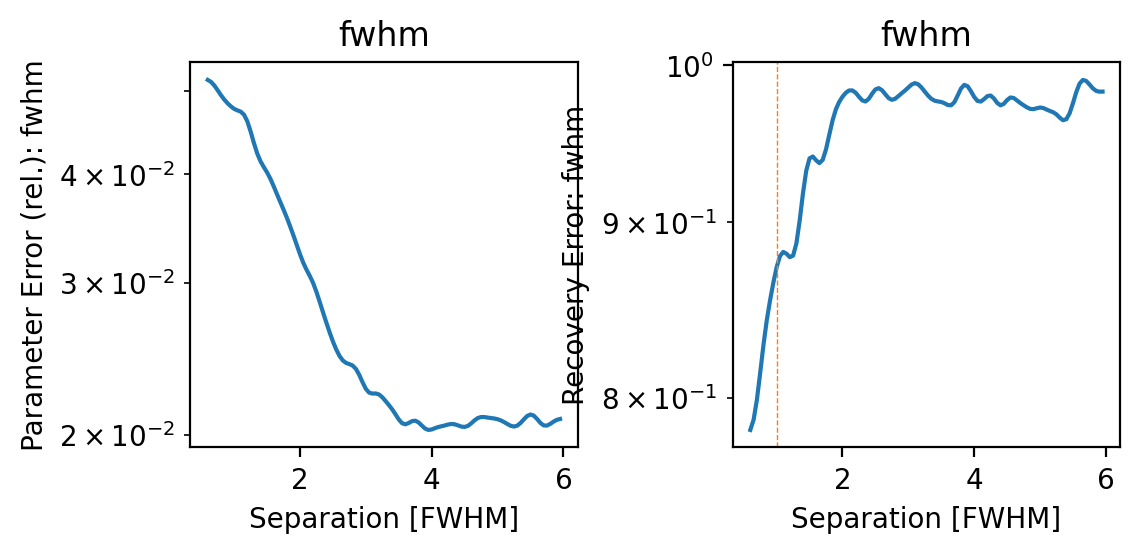

In [878]:
from scipy.ndimage import gaussian_filter1d

for i, par_name in enumerate(list(start_params.keys())):
    #=== make a figure: plot the errors
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2.5), dpi=200, 
                                   gridspec_kw={'wspace': 0.4})
    ax1.set_xlabel('Separation [FWHM]')
    ax1.set_ylabel(f'Parameter Error (rel.): {par_name}')
    err_smooth = gaussian_filter1d(param_errors[:, i], sigma=2, axis=0)
    ax1.plot(sep_array, err_smooth, color='C0', ls='-')
    ax1.set_title(par_name)
    ax1.set_yscale('log')
    #ax1.legend()
    
    ax2.set_xlabel('Separation [FWHM]')
    ax2.set_ylabel(f'Recovery Error: {par_name}')
    err_smooth = gaussian_filter1d(recovery_errors[:, i], sigma=2, axis=0)
    ax2.plot(sep_array, err_smooth, color='C0', ls='-')
    ax2.set_title(par_name)
    ax2.set_yscale('log')
    #ax2.legend()
    ax2.axvline(1, color='C1', ls='--', lw=0.5)
    plt.show()

In [920]:
wavs = np.array([3722, 3727, 3729, 6565])
fwhm_disp = np.array([200, 10, 150, 120])
sep_fwhm_kms = np.diff(wavs) / np.array(wavs[:-1]) * 3e5
unresolved = 2 * fwhm_disp[:-1] > sep_fwhm_kms # resolution too poor
#wavs[1:][unresolved], np.argwhere(unresolved).item()+1
unresolved, #np.delete(wavs, np.argwhere(unresolved).item()+1)
unresolved.any()

False

In [950]:
line_keys_set = ['3722', '3727', '3729', '6565']
line_wavs_set = np.array([3722, 3727, 3729, 3731])
fwhm_intrum_list = np.array([200, 150, 150, 120])

line_wavs_set = np.array(line_wavs_set)
fwhm_intrum_list = np.array(fwhm_intrum_list)
sep_fwhm_kms = np.diff(line_wavs_set) /\
                line_wavs_set[:-1] * 3e5
unresolved = 2*fwhm_intrum_list[:-1] > sep_fwhm_kms
if unresolved.any():
    idx2remove = np.argwhere(unresolved).flatten() + 1
    line_wavs_set = np.delete(line_wavs_set, idx2remove)
    lines_combined = [line_keys_set[i] \
        for i in np.insert(idx2remove, 0, idx2remove[0]-1)]
    merged_lines = '_'.join([line for line in lines_combined])
    line_keys_set[idx2remove[0]-1] = merged_lines
    line_keys_set = [key for key in line_keys_set \
                        if not key in merged_lines[1:]]
    print(f"  - unresolved lines: {lines_combined}")

  - unresolved lines: ['3727', '3729', '6565']


In [732]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

def find_inflection_points(x, sigma=3):
    # Smooth data
    x_smooth = gaussian_filter1d(x, sigma=sigma, axis=0)

    # First and second derivatives
    dx = np.gradient(x_smooth, axis=0)
    ddx = np.gradient(dx, axis=0)

    # Inflection points = where second derivative changes sign
    inflection_mask = np.diff(np.sign(ddx), axis=0) != 0
    inflection_indices = np.where(inflection_mask)
    
    # Optional: filter weak inflection points based on prominence of curvature
    significant = np.abs(ddx[inflection_indices]) > 0.3 * np.abs(ddx[inflection_indices]).max()
    return np.c_[inflection_indices][significant]

[[sep_array[pt[0]], pt[1]] for pt in find_inflection_points(recovery_errors)]

[[1.3000000000000003, 2],
 [1.5000000000000004, 1],
 [1.5000000000000004, 3],
 [2.7000000000000015, 2],
 [14.200000000000012, 2]]

In [111]:
import pymc as pm

x_fit = x_kms.copy()

start_params = {
    "A1": 5,
    "A2": 5,
    "peak1": peak1_kms,
    "peak2": peak2_kms,
    "fwhm": fwhm_kms,
}

model = pm.Model()
with model:
    A1 = pm.Uniform(f"A1", lower=0, upper=10)
    A2 = pm.Uniform(f"A2", lower=0, upper=10)
    peak1 = pm.Uniform(f"peak1", lower=-peak2_kms*10, upper=peak2_kms*10)
    peak2 = pm.Uniform(f"peak2", lower=-peak2_kms*10, upper=peak2_kms*10)
    fwhm = pm.Uniform(f"fwhm", lower=0, upper=fwhm_kms*10)
    sig = fwhm / 2.355
    
    Y_line1 = pm.Deterministic(
        f'Y1', A1 * np.exp(-0.5 * (x_fit - peak1)**2 / sig**2))
    
    Y_line2 = pm.Deterministic(
        f'Y2', A2 * np.exp(-0.5 * (x_fit - peak2)**2 / sig**2))
    Y_mu = Y_line1 + Y_line2
    Y_pred = pm.Normal("Y_pred", mu=Y_mu, sigma=ye_mock, observed=y_mock)
    
    mle = pm.find_MAP(method='L-BFGS-B', #'powell',
                      start=start_params) # 'L-BFGS-B'
    
    var_names = [rv.name for rv in model.free_RVs]
    par_mle = dict(
        zip(var_names, [mle[key] for key in var_names]) )

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'A1_interval__': array(0.), 'A2_interval__': array(0.), 'peak1_interval__': array(0.), 'peak2_interval__': array(0.2006707), 'fwhm_interval__': array(-2.19722458)}

Logp initial evaluation results:
{'A1': -1.39, 'A2': -1.39, 'peak1': -1.39, 'peak2': -1.4, 'fwhm': -2.41, 'Y_pred': -inf}
You can call `model.debug()` for more details.

In [110]:
start_params

{'A1': 0.5, 'A2': 0.5, 'peak1': 0.0, 'peak2': 600.0, 'fwhm': 200}